In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from warnings import simplefilter

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Linear Regression

The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:

    target = weight_1 * feature_1 + weight_2 * feature_2 + bias
    
During training, the regression algorithm learns values for the parameters weight_1, weight_2, and bias that best fit the target. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

In [13]:
# Load Dataset
tunnel = pd.read_csv('Datasets/TSData/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')

In [15]:
# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

In [18]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


## Time-Step

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [21]:
from sklearn.linear_model import LinearRegression

In [19]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

In [20]:
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [22]:
# Training Data
X = df.loc[:, ['Time']] # features
y = df.loc[:, 'NumVehicles'] # target

In [23]:
# Train the Model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [24]:
# Store fitted values as a time series
y_pred = pd.Series(model.predict(X), index=X.index)

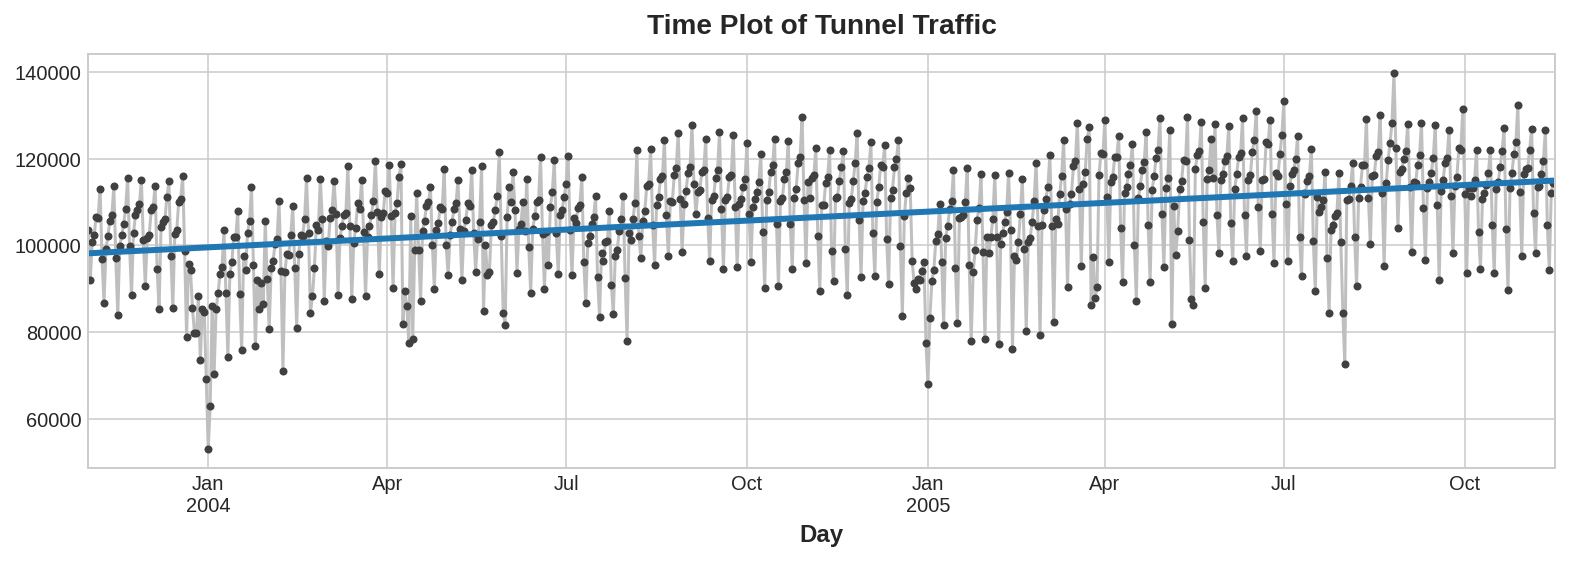

In [27]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## Lag Feature

When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [31]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [32]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)
y = df.loc[:, 'NumVehicles']
y, X = y.align(X, join='inner')

In [33]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [34]:
y_pred = pd.Series(model.predict(X), index=X.index)

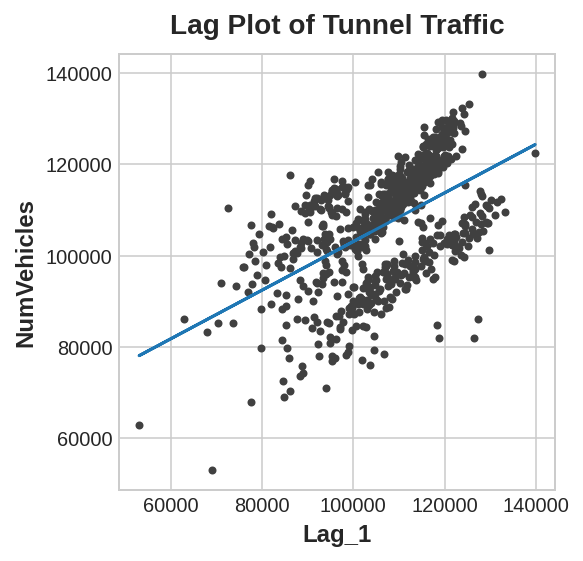

In [35]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

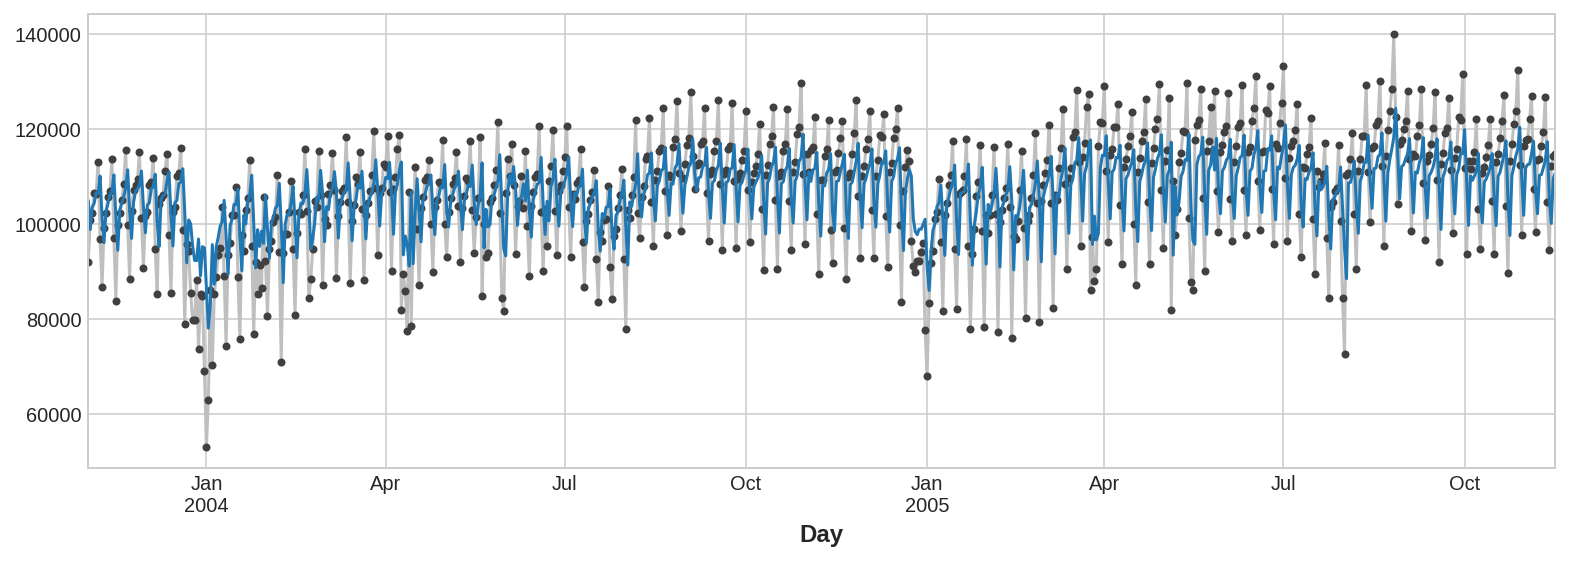

In [36]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of time-step features and lag features!

# Trends

The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. 

In [60]:
# Load Dataset
tunnel = pd.read_csv('Datasets/TSData/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')

In [61]:
moving_average = tunnel.rolling(
    window=365,
    center=True,
    min_periods = 183).mean()

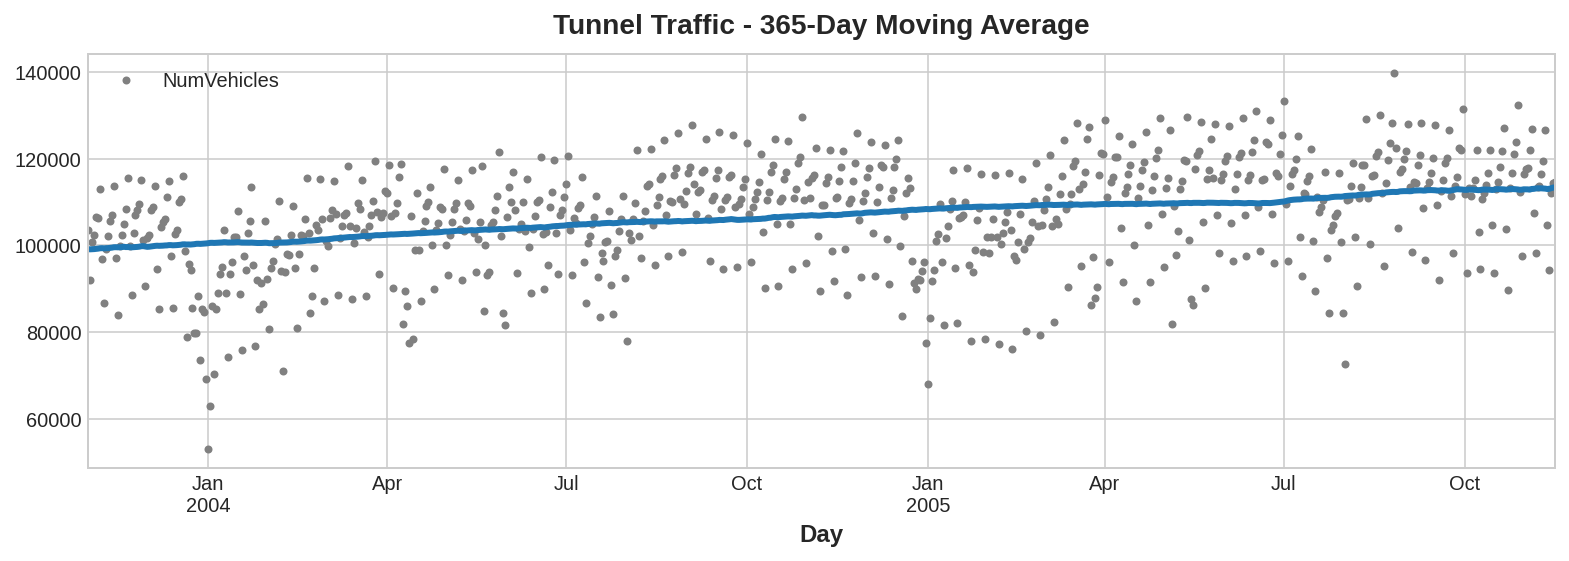

In [62]:
ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [63]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [43]:
from sklearn.linear_model import LinearRegression

In [45]:
# Target
y = tunnel.NumVehicles

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

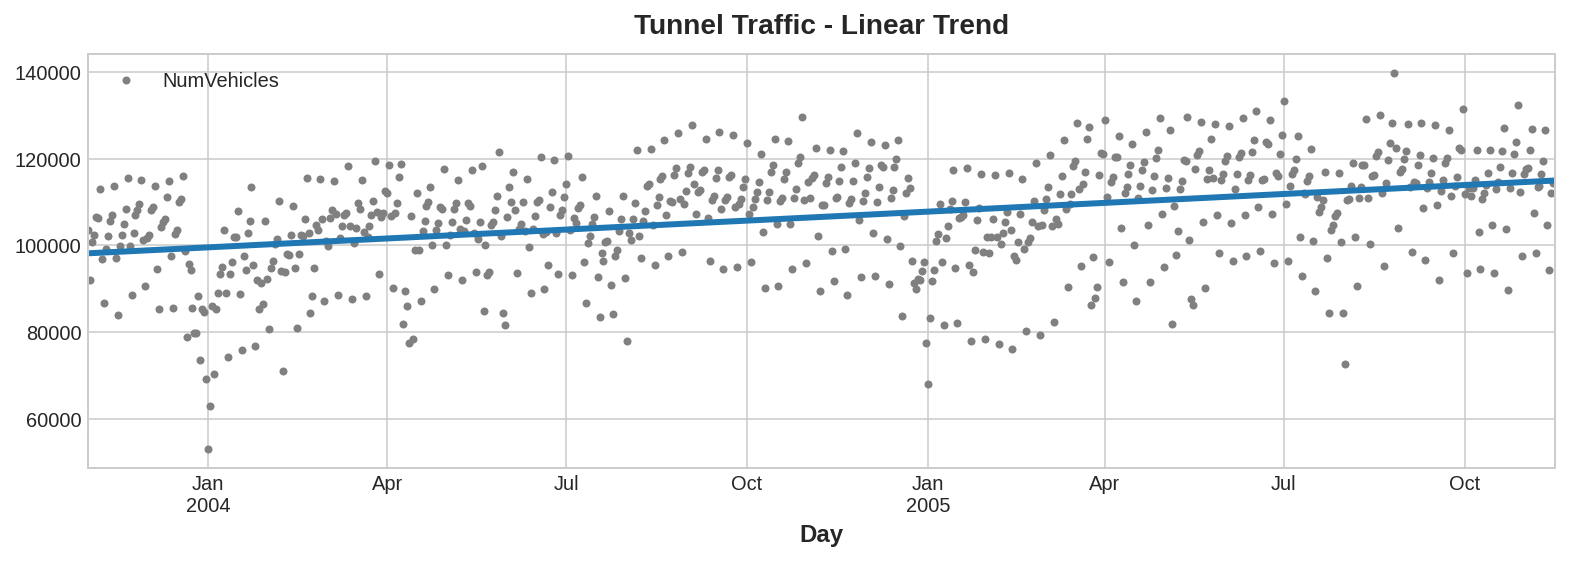

In [47]:
y_pred = pd.Series(model.predict(X), index=X.index)
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast we apply the model to 'out of sample' features

In [72]:
X_fore = dp.out_of_sample(steps=30)

/home/miguelpimentel/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [90]:
import datetime as dt

new_index = []
for i in range(1, 31, 1):
    new_index.append(X.index[-1] + dt.timedelta(days=i))

In [94]:
X_fore.index = new_index

In [95]:
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
dtype: float64

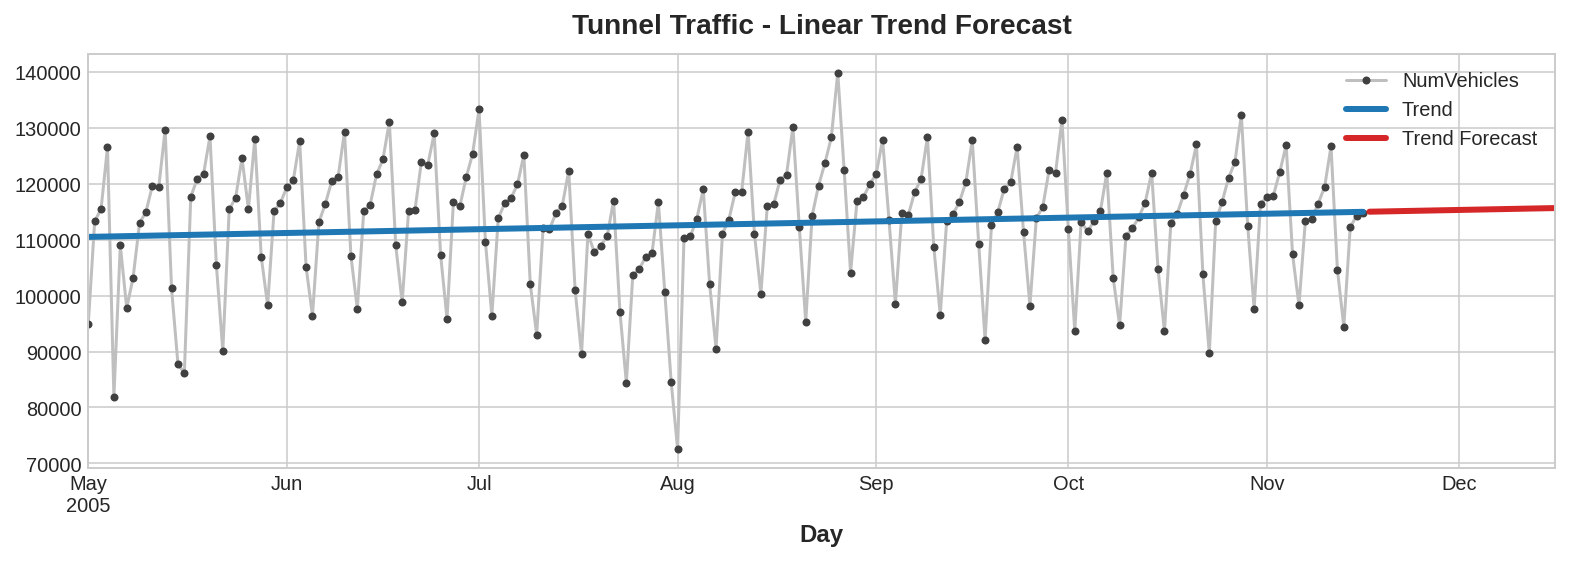

In [96]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. There are two kinds of features that model seasonality: **Indicators** (best for a season with few observations) and **Fourier features** (best for a season with many observations).

## Seasonal Indicators

Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.